In [16]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
import open3d as o3d  # type: ignore
from projections import camera_to_image, world_to_camera, filter_pixel_points
from utils import get_cameras, get_extrinsic_matrix, get_intrinsic_matrix 
from utils import save_ply

In [17]:
# Read the point cloud
gaussian_file = './point_cloud/iteration_30000/point_cloud.ply' 

In [18]:
pcd = o3d.io.read_point_cloud(gaussian_file)

In [19]:
pcd_array = np.asarray(pcd.points)
pcd_array = torch.from_numpy(pcd_array)
print(pcd_array)

tensor([[ -0.1773,   1.4565,  -0.6173],
        [ -0.2395,  -0.2551,   1.3519],
        [ -0.5875,  -0.3807,  -0.1670],
        ...,
        [ 14.6480,  -0.6251, -26.5749],
        [  0.2383,  -8.9183,  24.5446],
        [-34.5657,  -8.3790,   3.8361]], dtype=torch.float64)


In [20]:
# save_ply(pcd_array) 

### Converting World Coordinates to Pixel Coordinates

In [21]:
# Get Cameras 

cameras = get_cameras('cameras.json')  
i = 15
print('Image Name: ', cameras[i]['img_name'])

# WIDTH = cameras[i]['width'] 
# HEIGHT = cameras[i]['height'] 

WIDTH = cameras[i]['width'] 
HEIGHT = cameras[i]['height']

# Get Extrinsic & intrinsic Matrices for first camera 
extrinsic = get_extrinsic_matrix(cameras[i])  
intrinsic = get_intrinsic_matrix(cameras[i]) 

Image Name:  000121


In [22]:
# Convert to Camera Coordinates 
camera_coords = world_to_camera(pcd_array, extrinsic) 
print(camera_coords) 

tensor([[ -1.3128,   0.8392,  -0.6652,  ..., -26.3548,  24.8861,   3.1334],
        [  0.4786,  -0.9966,  -1.3347,  ...,  -2.5285,  -6.8881, -13.1983],
        [  5.4150,   5.3544,   5.6117,  ..., -10.7645,   4.8875,  38.4651]],
       dtype=torch.float64)


In [23]:
# Convert Camera Coordinates to Pixel Coordinates 
pixel_coords, points_depths = camera_to_image(camera_coords, intrinsic) 
print(pixel_coords) 

tensor([[  696,  1160,   840,  ..., -4538,  6901,  1073],
        [  647,   330,   270,  ...,  -866, -1084,   148]], dtype=torch.int32)


In [24]:
# Filter points outside the image width and height  

filt_points, filt_indices = filter_pixel_points(pixel_coords, WIDTH, HEIGHT) 

print(filt_indices)
print(filt_points) 

tensor([ True,  True,  True,  ..., False, False,  True])
tensor([      0,       1,       2,  ..., 1834478, 1834479, 1834482])
tensor([[ 696, 1160,  840,  ..., 1334,  680, 1073],
        [ 647,  330,  270,  ...,  233,  264,  148]], dtype=torch.int32)


In [25]:
filt_points.t()

tensor([[ 696,  647],
        [1160,  330],
        [ 840,  270],
        ...,
        [1334,  233],
        [ 680,  264],
        [1073,  148]], dtype=torch.int32)

In [26]:
img = torch.zeros((HEIGHT, WIDTH))  

x = filt_points.t()[:, 0].squeeze() 
y = filt_points.t()[:, 1].squeeze()   

img[y, x] = 1
print(img)

tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [27]:
from PIL import Image 

im = Image.fromarray((img.numpy()*255).astype(np.uint8), 'L')

name = 'output.png'
im.save(name) 

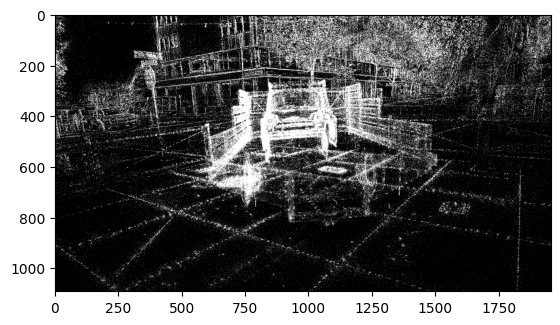

In [28]:
# Visualize grayscale projected view 

import matplotlib.pyplot as plt 

# We get inverted projection, so I will rotate 

# img = np.rot90(img.numpy(), 2) 
# img = torch.fliplr(img) 

plt.imshow(img, cmap='gray') 
plt.show()

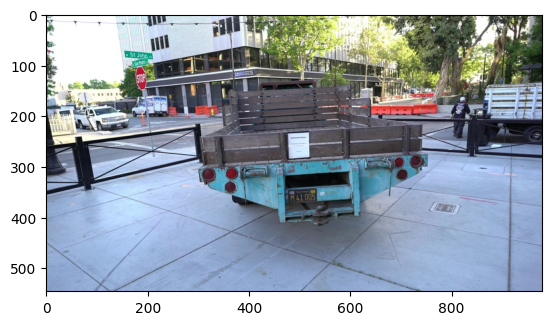

In [29]:
# place image dataset in the ../dataset directory
img_gt = plt.imread(f"../dataset/truck/images/{cameras[i]['img_name']}.jpg")
plt.imshow(img_gt)
plt.show()